<a href="https://colab.research.google.com/github/GAKIZAB/Time_series/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Analysis**

In [104]:
# Import necessary libraries
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima

from sklearn import preprocessing
import random

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2


# Step 1: Load the dataset and parse dates

In [74]:
# Data Loading
data = pd.read_csv('dataset.txt', parse_dates=['date'], index_col='date')
print(data.head())

               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869


In [5]:
# Display the basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


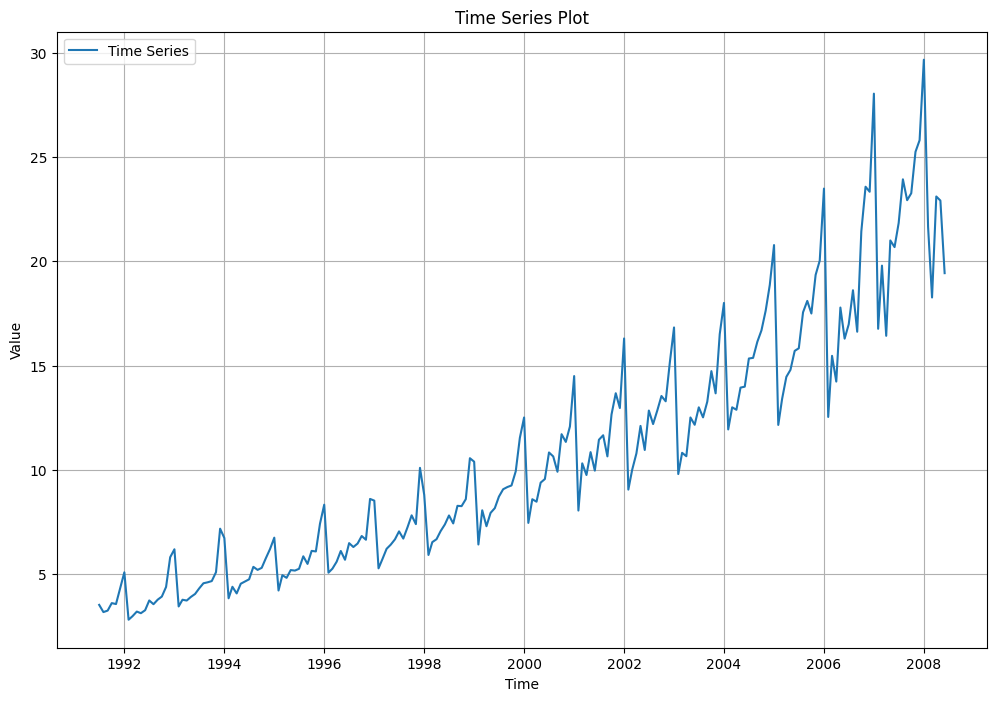

In [6]:
# Time Series Visualization
plt.figure(figsize=(12, 8))
plt.plot(data['value'], label='Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.show()

# Step 2: Stationarity Test (ADF Test)

In [7]:
# Apply the Augmented Dickey-Fuller test to check if the time series is stationary
result = adfuller(data['value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 3.14518568930673
p-value: 1.0


# Step 3: Function to perform the ADF test and determine the number of differences needed

In [8]:
# Determining Differencing Required
def test_adf(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

def determine_differencing(series, max_diff=3):
    diff_count = 0
    while diff_count < max_diff:
        p_value = test_adf(series)
        if p_value < 0.05:  # If p-value < 0.05, the series is stationary
            print(f"The series is stationary after {diff_count} differencing.")
            return diff_count
        series = series.diff().dropna()
        diff_count += 1
    print("The series is still not stationary after maximum differencing.")
    return diff_count

In [9]:
# Apply the differencing determination function
series = data['value']
differencing_needed = determine_differencing(series)
print(f'Differencing Needed: {differencing_needed}')

ADF Statistic: 3.14518568930673
p-value: 1.0
ADF Statistic: -2.4951721474497393
p-value: 0.11665341686468789
ADF Statistic: -10.29230470651732
p-value: 3.543916358529341e-18
The series is stationary after 2 differencing.
Differencing Needed: 2


# Step 4: Plot Original and Differenced Series

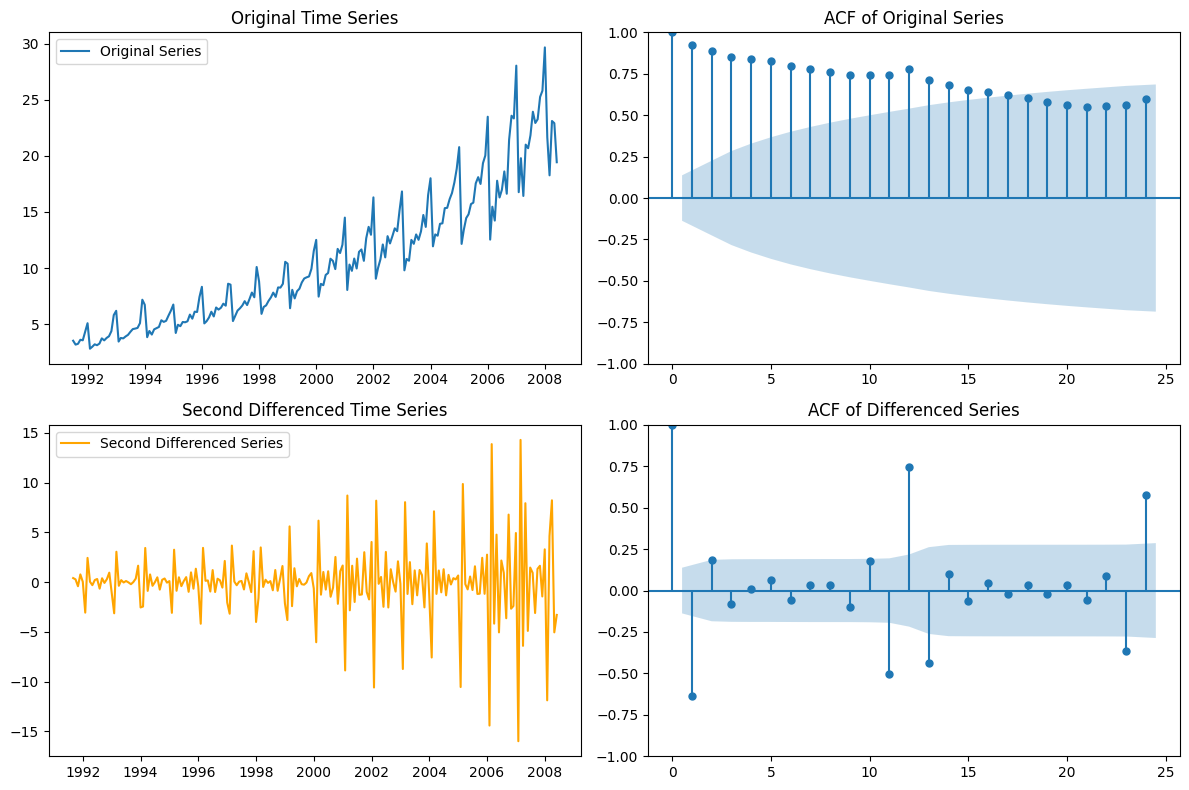

In [10]:
# Plot the original series and its differenced versions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original Time Series
axes[0, 0].plot(series, label='Original Series')
axes[0, 0].set_title('Original Time Series')
axes[0, 0].legend()

# ACF of Original Time Series
plot_acf(series, ax=axes[0, 1])
axes[0, 1].set_title('ACF of Original Series')

# Differenced Series
series_diff = series.diff().diff().dropna()
axes[1, 0].plot(series_diff, label='Second Differenced Series', color='orange')
axes[1, 0].set_title('Second Differenced Time Series')
axes[1, 0].legend()

# ACF of Differenced Series
plot_acf(series_diff, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Differenced Series')

plt.tight_layout()
plt.show()

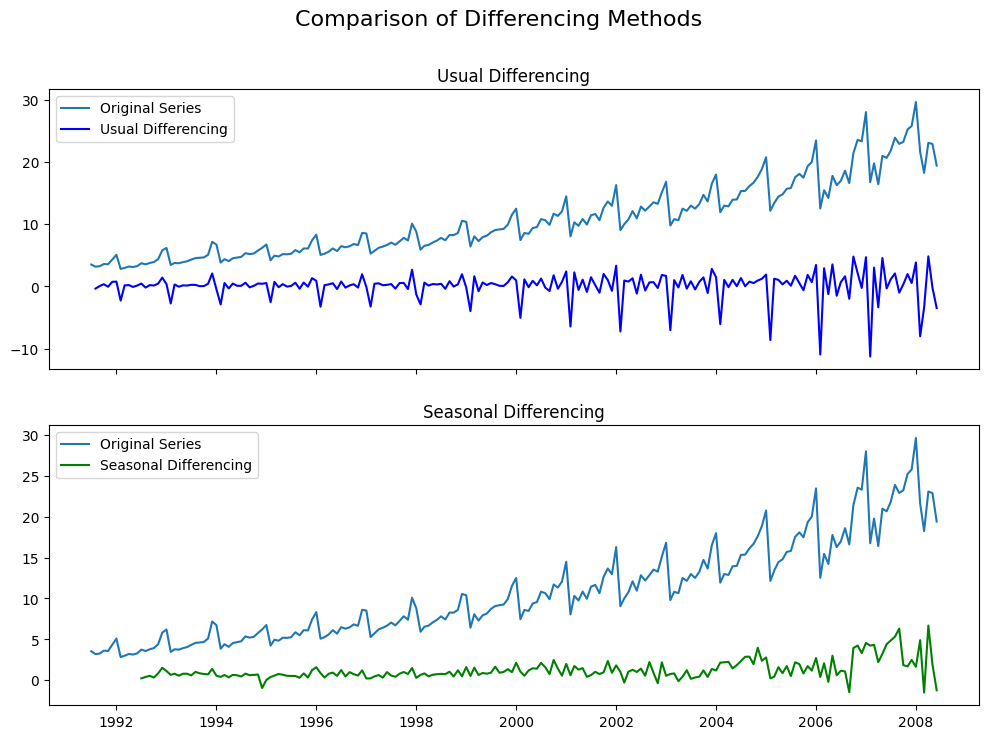

In [11]:
# Seasonal and Non-Seasonal Differencing Comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(series, label='Original Series')
axes[0].plot(series.diff(1), label='Usual Differencing', color='blue')
axes[0].set_title('Usual Differencing')
axes[0].legend()

# Seasonal Differencing
axes[1].plot(series, label='Original Series')
axes[1].plot(series.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend()

plt.suptitle('Comparison of Differencing Methods', fontsize=16)
plt.show()

In [30]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("La série n'est pas stationnaire. Appliquer une différenciation.")
    else:
        print("La série est stationnaire.")

# Appliquer une différenciation si nécessaire
series = data.diff().diff().dropna()
check_stationarity(data_diff.values.flatten())


ADF Statistic: -10.29230470651732
p-value: 3.543916358529341e-18
La série est stationnaire.


# Step 5: **SARIMA** Model

In [34]:
# Supprimer les warnings
import warnings
warnings.filterwarnings("ignore")

In [48]:
# 1. create training data for sarima, remove the last n_periods for testing
n_periods = 12 # same as the prediction periods used before
train_series_sarima = series[:-n_periods]
test_series_sarima = series[-n_periods:]
# fit the model to the training data
model_sarima = auto_arima(train_series_sarima, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=None, D=1, trace=False,
                   error_action='ignore', suppress_warnings=True, stepwise=True)
# make the predictions
predictions_sarima = model_sarima.predict(n_periods=n_periods)
y_test_sarima = test_series_sarima.values # get the true values

In [49]:
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  190
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -242.160
Date:                            Mon, 06 Jan 2025   AIC                            496.321
Time:                                    20:15:28   BIC                            515.411
Sample:                                09-01-1991   HQIC                           504.063
                                     - 06-01-2007                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2951      0.058    -22.143      0.000      -1.410      -1.180
ar.L2         -0.8682      0.085   

# Step 6: Model Diagnostics

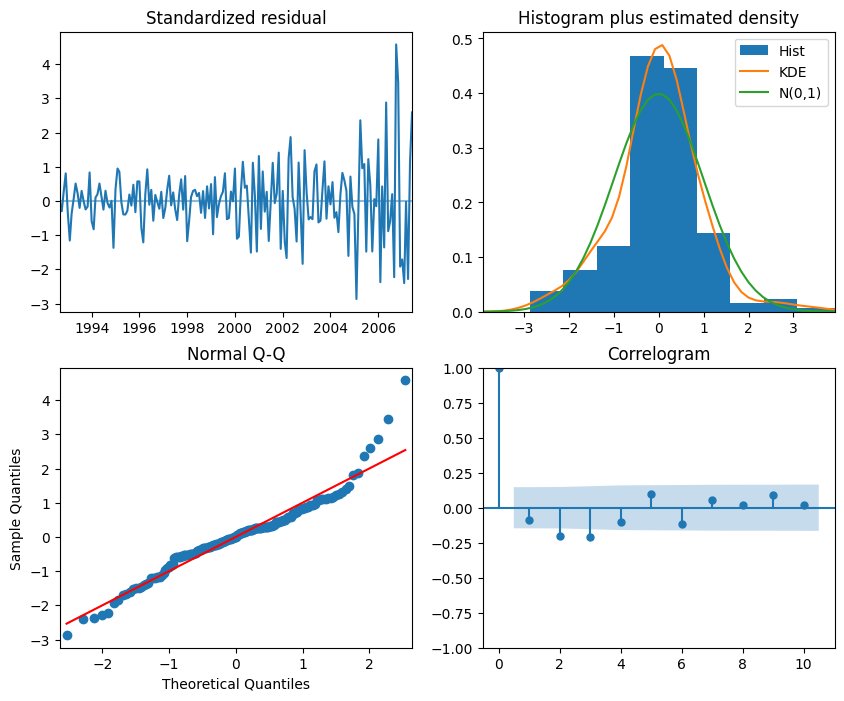

In [50]:
# Plot diagnostic plots for the ARIMA model
model_sarima.plot_diagnostics(figsize=(10, 8))
plt.show()

# Step 7: Model Prediction

In [51]:
# Make predictions for the next 12 periods
fitted, confint = model_sarima.predict(n_periods=12, return_conf_int=True)

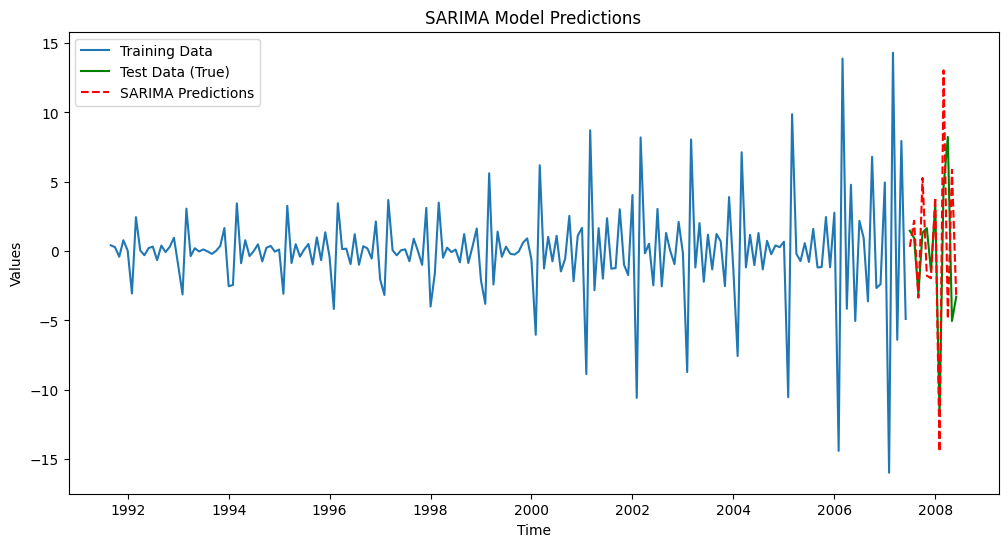

In [59]:
# Convert predictions to a time series for alignment
predictions_sarima_series = pd.Series(predictions_sarima, index=test_series_sarima.index)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train_series_sarima, label='Training Data')
plt.plot(test_series_sarima, label='Test Data (True)', color='green')
plt.plot(predictions_sarima_series, label='SARIMA Predictions', color='red', linestyle='--')
plt.title('SARIMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcul de la RMSE
rmse_sarima = np.sqrt(mean_squared_error(y_test_sarima, predictions_sarima))
print(f"RMSE des prédictions SARIMA : {rmse_sarima}")


RMSE des prédictions SARIMA : 5.764356555151432


# Step 8 : **LSTM**

In [105]:

train_data = data.values[:-n_periods]
test_data = data.values[-n_periods:]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [106]:
print(train_data[:5,])
print(train_data_normalized[:5,])

[3.526591 3.180891 3.252221 3.611003 3.565869]
[[-0.94353989]
 [-0.97095044]
 [-0.96529469]
 [-0.93684687]
 [-0.94042554]]


In [107]:
train_data_normalized = torch.FloatTensor(train_data_normalized)
train_data_normalized

tensor([[-0.9435],
        [-0.9710],
        [-0.9653],
        [-0.9368],
        [-0.9404],
        [-0.8817],
        [-0.8197],
        [-1.0000],
        [-0.9864],
        [-0.9691],
        [-0.9752],
        [-0.9638],
        [-0.9268],
        [-0.9410],
        [-0.9237],
        [-0.9120],
        [-0.8754],
        [-0.7624],
        [-0.7322],
        [-0.9495],
        [-0.9241],
        [-0.9271],
        [-0.9135],
        [-0.9021],
        [-0.8810],
        [-0.8614],
        [-0.8577],
        [-0.8530],
        [-0.8193],
        [-0.6539],
        [-0.6894],
        [-0.9186],
        [-0.8748],
        [-0.9000],
        [-0.8631],
        [-0.8548],
        [-0.8463],
        [-0.7989],
        [-0.8105],
        [-0.8028],
        [-0.7654],
        [-0.7312],
        [-0.6880],
        [-0.8889],
        [-0.8307],
        [-0.8407],
        [-0.8113],
        [-0.8132],
        [-0.8064],
        [-0.7589],
        [-0.7878],
        [-0.7383],
        [-0.

In [108]:
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([[-0.9435],
          [-0.9710],
          [-0.9653],
          [-0.9368],
          [-0.9404],
          [-0.8817],
          [-0.8197],
          [-1.0000],
          [-0.9864],
          [-0.9691],
          [-0.9752],
          [-0.9638]]),
  tensor([[-0.9268]])),
 (tensor([[-0.9710],
          [-0.9653],
          [-0.9368],
          [-0.9404],
          [-0.8817],
          [-0.8197],
          [-1.0000],
          [-0.9864],
          [-0.9691],
          [-0.9752],
          [-0.9638],
          [-0.9268]]),
  tensor([[-0.9410]])),
 (tensor([[-0.9653],
          [-0.9368],
          [-0.9404],
          [-0.8817],
          [-0.8197],
          [-1.0000],
          [-0.9864],
          [-0.9691],
          [-0.9752],
          [-0.9638],
          [-0.9268],
          [-0.9410]]),
  tensor([[-0.9237]])),
 (tensor([[-0.9368],
          [-0.9404],
          [-0.8817],
          [-0.8197],
          [-1.0000],
          [-0.9864],
          [-0.9691],
          [-0.9752]

In [109]:
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


In [110]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [112]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.01350898
epoch:  26 loss: 0.00021840
epoch:  51 loss: 0.00238111
epoch:  76 loss: 0.00996557
epoch: 101 loss: 0.00004331
epoch: 126 loss: 0.00006238
epoch: 149 loss: 0.0001251647


RMSE: 4.949358980829396
MAE: 4.247450474558816
    Predictions     Actual
0     16.991807  21.834890
1     21.644799  23.930204
2     25.295033  22.930357
3     25.628762  23.263340
4     28.893415  25.250030
5     20.118057  25.806090
6     27.784342  29.665356
7     24.611727  21.654285
8     27.174637  18.264945
9     28.868135  23.107677
10    23.757288  22.912510
11    28.857758  19.431740


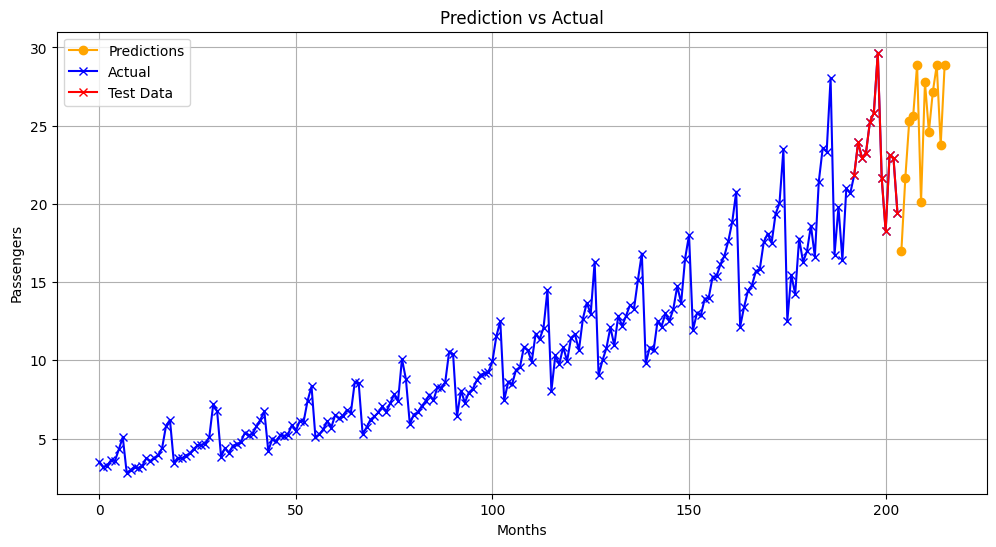

In [114]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

fut_pred = 24
n_periods = 12 # Number of periods predicted

# Créer une liste vide pour stocker les prédictions
test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()
predictions = []

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        # Initialize hidden state for each prediction
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())
        test_inputs.append([predictions[-1]])

# Inverse transform pour obtenir les valeurs réelles
actual_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Calculer RMSE
rmse = np.sqrt(np.mean((actual_predictions[:n_periods] - test_data) ** 2))
# Calculer MAE
mae = mean_absolute_error(test_data, actual_predictions[:n_periods])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Afficher les prédictions et les valeurs réelles
comparison_df = pd.DataFrame({'Predictions': actual_predictions[:n_periods].flatten(), 'Actual': test_data})
print(comparison_df)

# Graphique
plt.figure(figsize=(12, 6))
x = np.arange(len(data), len(data) + len(actual_predictions[:n_periods]))
plt.plot(x, actual_predictions[:n_periods], label='Predictions', color='orange', marker='o')
plt.plot(np.arange(len(data)), data, label='Actual', color='blue', marker='x')
plt.plot(np.arange(len(data)-n_periods, len(data)),test_data, label='Test Data', color='red', marker='x')

plt.xlabel('Months')
plt.ylabel('Passengers')
plt.title('Prediction vs Actual')
plt.legend()
plt.grid()
plt.show()

In [115]:
# Calcul de la RMSE et MAE pour SARIMA (déjà présent dans le code)
rmse_sarima = np.sqrt(mean_squared_error(y_test_sarima, predictions_sarima))
mae_sarima = mean_absolute_error(y_test_sarima, predictions_sarima)

print(f"RMSE du modèle SARIMA : {rmse_sarima}")
print(f"MAE du modèle SARIMA : {mae_sarima}")

# Calcul de la RMSE et MAE pour LSTM (déjà présent dans le code)
rmse_lstm = np.sqrt(np.mean((actual_predictions[:n_periods] - test_data) ** 2))
mae_lstm = mean_absolute_error(test_data, actual_predictions[:n_periods])

print(f"RMSE du modèle LSTM : {rmse_lstm}")
print(f"MAE du modèle LSTM : {mae_lstm}")

# Comparaison des métriques
print("\nComparaison des modèles :")
print(f"RMSE : SARIMA = {rmse_sarima:.4f}, LSTM = {rmse_lstm:.4f}")
print(f"MAE : SARIMA = {mae_sarima:.4f}, LSTM = {mae_lstm:.4f}")

if rmse_sarima < rmse_lstm:
    print("Le modèle SARIMA a une meilleure RMSE.")
elif rmse_lstm < rmse_sarima:
    print("Le modèle LSTM a une meilleure RMSE.")
else:
    print("Les deux modèles ont la même RMSE.")

if mae_sarima < mae_lstm:
    print("Le modèle SARIMA a une meilleure MAE.")
elif mae_lstm < mae_sarima:
    print("Le modèle LSTM a une meilleure MAE.")
else:
    print("Les deux modèles ont la même MAE.")

RMSE du modèle SARIMA : 5.764356555151432
MAE du modèle SARIMA : 3.8539509885373398
RMSE du modèle LSTM : 4.949358980829396
MAE du modèle LSTM : 4.247450474558816

Comparaison des modèles :
RMSE : SARIMA = 5.7644, LSTM = 4.9494
MAE : SARIMA = 3.8540, LSTM = 4.2475
Le modèle LSTM a une meilleure RMSE.
Le modèle SARIMA a une meilleure MAE.
